# Stock Selection using Deep Learning
by Chee-Foong（曾志峰）from Singapore（新加坡）on 19 Jul 2020

## Summary

**This is an extension to an earlier analysis: [机器学习选股心得（英语）](https://www.joinquant.com/view/community/detail/da8707fce7f3c80794d52ac56d2d735e?type=1):**

- Deep Learning model, instead of Machine Learning, is used here
- Long and Short trading algorithm instead of a Long-Only trading algorithm
- This is still a multiclassification problem.  However, the number of target variable is reduced from 5 to 3.

Purpose of this analysis is to predict 1-month stock returns of securities in CSI 300.  Based on predicted returns performance, each stock will be assigned to different performance categories.  At the end of each month, we will go long on stocks predicted to have good performance and go short on stocks predicted to have poor performance.  

This process will repeat every month and the strategy will be backtested to determine with whether the prediction model is good enough for consistent outperformance over the index/benchmark.

I welcome any comments/feedbacks on this analysis.  If you spot any mistakes, please let me know.


### References
Thank you to the authors of the following references for their work and sharing what they have done.
1. [A Sustainable Quantitative Stock Selection Strategy Based on Dynamic Factor Adjustment](https://www.researchgate.net/publication/341376900_A_Sustainable_Quantitative_Stock_Selection_Strategy_Based_on_Dynamic_Factor_Adjustment)
2. [Stock selection strategy of A-share market based on rotation effect and random forest](https://www.researchgate.net/publication/341596634_Stock_selection_strategy_of_A-share_market_based_on_rotation_effect_and_random_forest)

---
## Loading the libraries

In [ ]:
import time
import re
import random
import numpy as np
import pandas as pd

Preparing list of factors of interest.  List of factors here are selected based on the first reference research paper.  I have not had time to look through all the factors avaialble on JQData and select my own.

In [ ]:
factors = {'net_profit_to_total_operate_revenue_ttm': 'Quality',
 'DEGM': 'Quality',
 'roe_ttm': 'Quality',
 'GMI': 'Quality',
 'ACCA': 'Quality',
 'financial_liability': 'Fundamental',
 'cash_flow_to_price_ratio': 'Fundamental',
 'market_cap': 'Fundamental',
 'net_profit_ttm': 'Fundamental',
 'EBIT': 'Fundamental',
 'VOL20': 'Emotional',
 'DAVOL20': 'Emotional',
 'VOSC': 'Emotional',
 'VMACD': 'Emotional',
 'ATR14': 'Emotional',
 'PEG': 'Growth',
 'net_profit_growth_rate': 'Growth',
 'operating_revenue_growth_rate': 'Growth',
 'net_asset_growth_rate': 'Growth',
 'net_operate_cashflow_growth_rate': 'Growth',
 'Variance20': 'Risk',
 'sharpe_ratio_20': 'Risk',
 'Kurtosis20': 'Risk',
 'Skewness20': 'Risk',
 'sharpe_ratio_60': 'Risk',
 'net_asset_per_share': 'Stock',
 'net_operate_cash_flow_per_share': 'Stock',
 'eps_ttm': 'Stock',
 'retained_earnings_per_share': 'Stock',
 'cashflow_per_share_ttm': 'Stock',
 'ROC20': 'Momentum',
 'Volume1M': 'Momentum',
 'TRIX10': 'Momentum',
 'Price1M': 'Momentum',
 'PLRC12': 'Momentum',
 'MAC20': 'Technical',
 'boll_down': 'Technical',
 'boll_up': 'Technical',
 'MFI14': 'Technical',
 'size': 'Style',
 'beta': 'Style',
 'momentum': 'Style',
 'book_to_price_ratio': 'Style',
 'liquidity': 'Style',
 'growth': 'Style'}

In [ ]:
factor_list = []
for key in factors:
    factor_list.append(key)

In [ ]:
print(factor_list)

In [ ]:
print('Total number of factors: {}'.format(len(factor_list)))

## Extracting Data from JQData

### Factor data

Requests are sent on a batch basis due to limit to the amount of data to extract per request.  One factor per year per request.

In [ ]:
# 导入函数库
from jqfactor import get_factor_values

# benchmark_index = '000001.XSHG' ## 上证指数
benchmark_index = '000300.XSHG' ## 沪深300

stocks = get_index_stocks(benchmark_index) 

## TESTING PURPOSE
# factor_list = ['liquidity','Variance20','net_asset_growth_rate',
#                'VOSC','size','Price1M', 'net_profit_growth_rate', 
#                'sharpe_ratio_20', 'PEG', 'beta']

start_date = '2012-01-01'
end_date = '2020-07-01'

year_list = pd.date_range(start_date, end_date, freq='YS').strftime("%Y-%m-%d").tolist()
year_list.append(end_date)

In [ ]:
def getSymbolName(symbol):
    info = get_security_info(symbol)
    return info.display_name, info.name

In [ ]:
security_list = []

stock_N_bmk = stocks + [benchmark_index]
for stock in stock_N_bmk:
    security = {}
    display_name, stock_name = getSymbolName(stock)
    security['symbol'] = stock
    security['display_name'] = display_name
    security['stock_name'] = stock_name
    security_list.append(security)
    
security_list = pd.DataFrame(security_list).set_index('symbol')
security_list.head()

In [ ]:
factor_tablelist = []

for i in range(len(year_list)-1):

    factor_all_data = {}
    for factor in factor_list:
            factor_data = get_factor_values(securities=stocks, 
                                            factors=factor, 
                                            start_date=year_list[i], end_date=year_list[i+1])

            factor_all_data.update(factor_data)
            
    factor_yearlist = []

    for factor in factor_list:
        factor_table = factor_all_data[factor].resample('M').last()
        factor_table['factor'] = factor
        factor_table = factor_table.reset_index() \
                .rename(columns = {'index': 'date'}).set_index(['date','factor'])
        factor_yearlist.append(factor_table)

    factor_yearlist = pd.concat(factor_yearlist)
    factor_yearlist.sort_index(ascending=True, inplace=True)
    factor_tablelist.append(factor_yearlist)

Consolidating the data into a complete table.  Only monthend data is required in this analysis.

In [ ]:
factor_data = pd.concat(factor_tablelist)
factor_data.sort_index(ascending=True, inplace=True)

In [ ]:
factor_data.shape

### Price data

In [ ]:
prices = get_price(stocks, start_date=start_date, 
               end_date=end_date, frequency='daily', 
               fields=['close'])['close']

In [ ]:
prices = prices.resample('M').fillna('ffill')
returns = prices.pct_change().dropna(axis=0, how='all')

Calculating monthend returns

In [ ]:
monthly_returns = prices.pct_change().dropna(axis=0, how='all')
monthly_returns['factor'] = 'monthly_return'
monthly_returns = monthly_returns.reset_index() \
        .rename(columns = {'index': 'date'}).set_index(['date','factor'])
monthly_returns.head()

Creating the target variable - next month return

In [ ]:
next_mth_returns = prices.pct_change().dropna(axis=0, how='all')
next_mth_returns = next_mth_returns.shift(-1)
next_mth_returns.dropna(axis=0, how='all', inplace=True)
next_mth_returns['factor'] = 'next_mth_return'
next_mth_returns = next_mth_returns.reset_index() \
        .rename(columns = {'index': 'date'}).set_index(['date','factor'])
next_mth_returns.head()

Combining the factor and returns table together

In [ ]:
data = pd.concat([factor_data, monthly_returns, next_mth_returns])
data.sort_index(ascending=True, inplace=True)

In [ ]:
data.head(20)

### Benchmark Data

In [ ]:
bmk_start_date = '2012-01-01'
bmk_end_date = '2020-07-01'

bmk_prices = get_price('000300.XSHG', start_date=bmk_start_date, 
               end_date=bmk_end_date, frequency='daily', 
               fields=['close'])['close']
bmk_prices = pd.DataFrame(bmk_prices)
bmk_prices.index.name = 'date'

### Save Data

Saving the data in csv files for reuse as the data extraction from JQData takes time.  Once the data are saved, the remainder of the notebook can still run.  Data just need to be reloaded.

In [ ]:
data.to_csv('../data/full_data.csv', index=True)

In [ ]:
monthly_returns.to_csv('../data/monthly_returns.csv', index=True)

In [ ]:
security_list.to_csv('../data/security_ref.csv', index=True)

In [ ]:
bmk_prices.to_csv('../data/bmk_prices.csv', index=True)

# Begin Analysis

## Preparing Datasets for Model Training

### Loading saved data

In [91]:
# import time
import re
import random
import numpy as np
import pandas as pd
import os

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

## Changing the default settings
pd.options.display.max_columns = 50
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

For Reproducible Analysis, Seed Everything!

In [92]:
def seedeverything(seed = 3333): 
    random.seed(seed) 
    np.random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed) 
    tf.random.set_seed(seed)    
    
SEED = 3333
seedeverything(SEED)

In [93]:
monthly_returns = pd.read_csv('../data/monthly_returns.csv')
monthly_returns.date = pd.to_datetime(monthly_returns.date)
monthly_returns = monthly_returns.set_index(['date', 'factor'])
monthly_returns.columns.name = 'code'

In [94]:
data = pd.read_csv('../data/full_data.csv')
data.date = pd.to_datetime(data.date)
data = data.set_index(['date', 'factor'])
data.columns.name = 'code'

In [95]:
security_list = pd.read_csv('../data/security_ref.csv')
security_list = security_list.set_index(['symbol'])

In [96]:
bmk_prices = pd.read_csv('../data/bmk_prices.csv')
bmk_prices.date = pd.to_datetime(bmk_prices.date)
bmk_prices = bmk_prices.set_index(['date'])

### Preparing Training dataset
Consolidate each monthly observations by features and their respective target in preparation for the training and testing dataset.

In [97]:
def getDataByDate(date):
    out = data.loc[pd.IndexSlice[date, :], :].T
    out.columns = out.columns.droplevel('date')
    out.columns.name = ''
    return out.reset_index()

In [98]:
train_startdate = '01-01-2015'
train_enddate = '01-01-2018'

date_list = pd.date_range(train_startdate, train_enddate, freq='M').strftime("%Y-%m").tolist()
print(date_list)

['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12']


Note that the data on the first and last month are not used for training for the following reasons:
- first month: Monthly return for the month cannot be calculated due to insufficient data
- last month: All data in the month will be used to predict the monthly return next month hence cannot be used for training the model

In [99]:
train = []
for date in date_list[1:-1]:
    out = getDataByDate(date)
    train.append(out)

train = pd.concat(train).reset_index(drop=True)

### Exploratory Data Analysis

Data analysis on the factors should be conducted here.  This may potentially lead to some factors being dropped because their are correlated with other factors or not meaningful in making a prediction on next month's return.  However, it is not the main focus of this analysis, so we will use all the factors as it is and see how the deep learning model performs.

Simple analysis on target variable

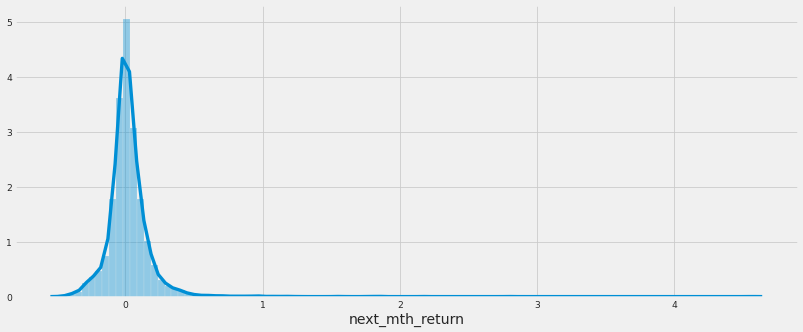

In [100]:
sns.distplot(train.next_mth_return, 100)
plt.show()

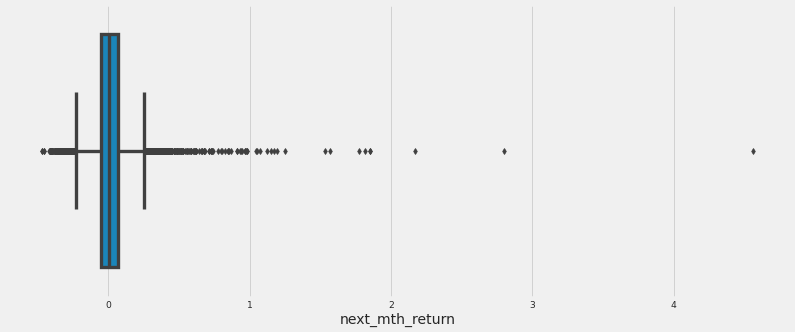

In [101]:
sns.boxplot(train.next_mth_return)
plt.show()

In [102]:
train.next_mth_return.describe()

count    8858.000000
mean        0.019458
std         0.157115
min        -0.470990
25%        -0.047670
50%         0.003814
75%         0.072645
max         4.565217
Name: next_mth_return, dtype: float64

### Data Cleaning

Removing observation with incomplete or missing data

In [103]:
train.dropna(axis=0, inplace=True)

Drop securities with less than 12 months of data.  We are only interested in securities with at least 1 year worth of data in the training dataset.

In [104]:
security_todrop = train.groupby('code').size()
minsize = 12

security_todrop = security_todrop[security_todrop.values < minsize].index.tolist()
print('Number of securities dropped: {}'.format(len(security_todrop)))
train = train[~train.code.isin(security_todrop)]

Number of securities dropped: 48


### Feature Engineering the Target

Categorise the target to **return_range**.  Note that this will cause in imbalanced dataset on a multiclassification problem in which we will try to fix via upsampling later.

| Return Category | LabelEncoded | Description |
| :-: | :-: | --- |
| A | 0 | Stocks with next month return more than 10% |
| B | 1 | Stocks with next month return between -10% and 10% |
| C | 2 | Stocks with next month return less than -10% |

In [105]:
train['return_range'] = pd.cut(train['next_mth_return'], 
       bins=[-float("inf"),-0.1,0.1,float("inf")], 
       right=False, labels=['C','B','A'])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train['return_range'] = le.fit_transform(train['return_range'])

Note that **code** will be dropped after resampling.

In [106]:
target = ['return_range']
to_drop = ['next_mth_return']
features = [column for column in train.columns if column not in target + to_drop]

### Splitting into Training and Validation dataset

Split data first before resampling.  

In [107]:
X = train[features]
y = train[target]

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=SEED)

### Normalising the datasets

- Fit and Transform on the training dataset
- Transform only on the validation dataset using the scaler fitted with training dataset

In [109]:
col_toscale = X_train.columns.tolist()
col_toscale.remove('code')
print('List of columns to scale: {}'.format(col_toscale))

List of columns to scale: ['ACCA', 'ATR14', 'DAVOL20', 'DEGM', 'EBIT', 'GMI', 'Kurtosis20', 'MAC20', 'MFI14', 'PEG', 'PLRC12', 'Price1M', 'ROC20', 'Skewness20', 'TRIX10', 'VMACD', 'VOL20', 'VOSC', 'Variance20', 'Volume1M', 'beta', 'boll_down', 'boll_up', 'book_to_price_ratio', 'cash_flow_to_price_ratio', 'cashflow_per_share_ttm', 'eps_ttm', 'financial_liability', 'growth', 'liquidity', 'market_cap', 'momentum', 'monthly_return', 'net_asset_growth_rate', 'net_asset_per_share', 'net_operate_cash_flow_per_share', 'net_operate_cashflow_growth_rate', 'net_profit_growth_rate', 'net_profit_to_total_operate_revenue_ttm', 'net_profit_ttm', 'operating_revenue_growth_rate', 'retained_earnings_per_share', 'roe_ttm', 'sharpe_ratio_20', 'sharpe_ratio_60', 'size']


In [110]:
def processStdScaler(train, valid, columns):
    
    train_scaled = train.copy()
    valid_scaled = valid.copy()

    scaler = StandardScaler()
    scaler.fit(train[columns])
    train_scaled[columns] = scaler.transform(train[columns])
    valid_scaled[columns] = scaler.transform(valid[columns])

    return train_scaled, valid_scaled, scaler

In [111]:
X_train_std, X_valid_std, scaler = processStdScaler(X_train, X_valid, col_toscale)

In [112]:
X_train = X_train_std
X_valid = X_valid_std

### Resampling the Training dataset
Resampling is only done on the training dataset due to imbalanced target variable.  Upsampling will be done and be only conducted after the training dataset is normalised.

In [113]:
y_train.groupby('return_range').size()

return_range
0     691
1    2267
2     408
dtype: int64

Observed imbalanced training data set as shown above

In [114]:
from sklearn.utils import resample

def upsample_byCol(data, column, code):
    maxN = data.groupby(column).size().max()

    df = data[data[column] == code]
    num = maxN - df.shape[0]
    if num > 0:
        df_more = resample(df, replace=True, n_samples=num, random_state=SEED)
        df = pd.concat([df, df_more])
    return df

Upsampling securities with fewer observations on training dataset only

In [115]:
Xy_train = pd.concat([X_train, y_train], axis = 1)

In [116]:
train_resample = []

return_ranges = Xy_train['return_range'].unique()
for return_range in return_ranges:
    code_resampled = upsample_byCol(Xy_train, 'return_range', return_range)
    train_resample.append(code_resampled)
    
Xy_train = pd.concat(train_resample).reset_index(drop=True)
Xy_train = Xy_train.sample(frac=1).reset_index(drop=True)

In [117]:
Xy_train.groupby('return_range').size()

return_range
0    2267
1    2267
2    2267
dtype: int64

After ensuring a balanced training dataset, prepare the features and target of the training and validation dataset respectively.

In [118]:
target = ['return_range']
to_drop = ['code']
features = [column for column in Xy_train.columns if column not in target + to_drop]

X_train = Xy_train[features]
y_train = Xy_train[target]

X_valid = X_valid[features]
y_valid = y_valid[target]

Prepare and check the class weights for model training later.

In [119]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train.return_range), 
                                                  np.array(y_train.return_range))
class_weights

array([1., 1., 1.])

### Prepare Training and Validation dataset for GridSearch

This will have to be done separately because we need the grid search to tune the parameters by validating against a dataset we provide and not automatically sampled from the training dataset that has been resampled.  We want samples in the validation dataset to be unseen in the training dataset.

In order to do this properly for GridSearchCV, we need to use PredefinedSplit and fit GridSearchCV with the full dataset.

In [120]:
Xy_trainGS = X_train.join(y_train)
Xy_validGS = X_valid.join(y_valid)

In [121]:
from sklearn.model_selection import PredefinedSplit

# Create a list where train data indices are -1 and validation data indices are 0
# eg: split_index = [-1 if x in X_train.index else 0 for x in X.index]
split_index = [-1] * Xy_trainGS.shape[0] + [0] * Xy_validGS.shape[0] 

# Use the list to create PredefinedSplit
pds_GridSearch = PredefinedSplit(test_fold = split_index)

In [122]:
Xy_GS = pd.concat([Xy_trainGS, Xy_validGS]).reset_index(drop=True) 
X_GS = Xy_GS[features]
y_GS = Xy_GS[target]

### One Hot Encoding for Target variable

In [123]:
targetOHE = OneHotEncoder(sparse=False, handle_unknown='error')

y_train_ohe = targetOHE.fit_transform(y_train)
y_train_ohe = pd.DataFrame(y_train_ohe, columns=targetOHE.get_feature_names())
print(y_train_ohe.shape)

y_valid_ohe = targetOHE.transform(y_valid)
y_valid_ohe = pd.DataFrame(y_valid_ohe, columns=targetOHE.get_feature_names())
print(y_valid_ohe.shape)

(6801, 3)
(374, 3)


In [124]:
y_GS_ohe = targetOHE.transform(y_GS)
y_GS_ohe = pd.DataFrame(y_GS_ohe, columns=targetOHE.get_feature_names())
print(y_GS_ohe.shape)

(7175, 3)


### Finalising the Datasets

Keeping a copy of the validation target dataframe for confusion matrix later

In [125]:
y_valid_org = y_valid.copy()

Convert to numpy arrays for tensorflow keras model training

In [126]:
X_train = np.array(X_train)
y_train = np.array(y_train_ohe)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid_ohe)

X_GS = np.array(X_GS)
y_GS = np.array(y_GS_ohe)

## Building Deep Learning Model

Loading the model libraries

In [127]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_validate

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error 

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [129]:
INPUTS = X_train.shape[1]
TRAINING_OBSERVATIONS = X_train.shape[0]
NUM_OF_OUTPUTS = y_train_ohe.shape[1]
print('Number of inputs to neural network: {}'.format(INPUTS))
print('Number of training observations: {}'.format(TRAINING_OBSERVATIONS))
print('Number of target outputs: {}'.format(NUM_OF_OUTPUTS))

Number of inputs to neural network: 46
Number of training observations: 6801
Number of target outputs: 3


### Defining model structure

In [130]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.AUC(multi_label=True, name='auc'),
#     tf.keras.metrics.TruePositives(name='tp'),
#     tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
#     tf.keras.metrics.FalseNegatives(name='fn'), 
#     tf.keras.metrics.Precision(name='precision'),
#     tf.keras.metrics.Recall(name='recall'),
]

def build_model(nodes=(4,4,4), activation='relu', learning_rate=0.002, input_dropout=0.05, metrics=METRICS):
    model = Sequential()

    model.add(Dense(nodes[0], input_shape=(INPUTS,), activation=activation, \
                    kernel_initializer='normal'))
    model.add(tf.keras.layers.Dropout(input_dropout))
    
    for node in nodes[1:]:
        model.add(Dense(node, activation=activation, kernel_initializer='normal'))
        model.add(tf.keras.layers.Dropout(input_dropout))

    model.add(Dense(NUM_OF_OUTPUTS, activation='softmax'))

    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)

#     model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)

    return model

### Hyperparameter Tuning
Setting the GridSearchCV parameters.  Limiting the number of parameters to tune here as the computation resources on the JoinQuant research environment is limited.

**Tunable Parameters**  
1. Number of the dense layer in the deep learning model
2. Activation function
3. Batch Size
4. Number of Training Epoch
5. Learning Rate for Optimiser
6. Dropout Ratio for the dropout layer

In [164]:
import itertools

layer1 = [16,32,64]
layer2 = [16,32,64]
layer3 = [16,32,64]
layers = [layer1, layer2, layer3]

NODES_LIST = list(itertools.product(*layers))
ACTIVATION_LIST = ['relu'] ## 'relu', 'sigmoid', 'tanh', 'leaky_relu'
BATCHSIZE_LIST = [1024]
EPOCHS_LIST = [200]
LEARNINGRATE_LIST = [0.001,0.0005]
INPUTDROPOUT_LIST = [0,0.3,0.5]

# Define the parameters to try out
params = {'nodes': NODES_LIST, 
          'activation': ACTIVATION_LIST, 
          'batch_size': BATCHSIZE_LIST, 
          'epochs': EPOCHS_LIST, 
          'input_dropout': INPUTDROPOUT_LIST, 
          'learning_rate': LEARNINGRATE_LIST}

print(params)

{'nodes': [(16, 16, 16), (16, 16, 32), (16, 16, 64), (16, 32, 16), (16, 32, 32), (16, 32, 64), (16, 64, 16), (16, 64, 32), (16, 64, 64), (32, 16, 16), (32, 16, 32), (32, 16, 64), (32, 32, 16), (32, 32, 32), (32, 32, 64), (32, 64, 16), (32, 64, 32), (32, 64, 64), (64, 16, 16), (64, 16, 32), (64, 16, 64), (64, 32, 16), (64, 32, 32), (64, 32, 64), (64, 64, 16), (64, 64, 32), (64, 64, 64)], 'activation': ['relu'], 'batch_size': [1024], 'epochs': [200], 'input_dropout': [0, 0.3, 0.5], 'learning_rate': [0.001, 0.0005]}


In [165]:
# Import KerasClassifier from keras wrappers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Create a KerasClassifier
grid_buildmodel = KerasClassifier(build_fn = build_model)

grid_search = GridSearchCV(grid_buildmodel, param_grid = params, 
                           cv = pds_GridSearch, #scoring='roc_auc_ovr',
                           verbose=0, return_train_score=True)

Fit using the GS dataset because using PredefinedSplit here

In [166]:
%%capture --no-display gridsearchlog

class_weights_dict = dict(enumerate(class_weights))
%time grid_search.fit(X_GS, y_GS, class_weight = class_weights_dict)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f16cc5da9d0>,
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['relu'], 'batch_size': [1024],
                         'epochs': [200], 'input_dropout': [0, 0.3, 0.5],
                         'learning_rate': [0.001, 0.0005],
                         'nodes': [(16, 16...),
                                   (16, 32, 16), (16, 32, 32), (16, 32, 64),
                                   (16, 64, 16), (16, 64, 32), (16, 64, 64),
                                   (32, 16, 16), (32, 16, 32), (32, 16, 64),
                                   (32, 32, 16), (32, 32, 32), (32, 32, 64),
                                   (32, 64, 16), (32, 64, 32), (32, 64, 64),
                                   (64, 16, 16), (64, 16, 32), (64, 16, 64),
                          

In [167]:
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print('The best score: {:.3f}'.format(best_score))
print('The optimal parameters: {}'.format(best_parameters))

The best score: 0.786
The optimal parameters: {'activation': 'relu', 'batch_size': 1024, 'epochs': 200, 'input_dropout': 0.5, 'learning_rate': 0.0005, 'nodes': (64, 64, 16)}


### Building Best Model 

Updating the model to use the best hyperparameters

In [168]:
NODES = ((64,64,16))
LR = 0.0005
ACTIVATION = 'relu'
EPOCHS = 200
BATCH_SIZE = 1024
INPUT_DROPOUT = 0.5
PATIENCE = int(EPOCHS * 0.1)    ## To reduce training time.  
                                ## Early stopping when there is no further 
                                ## improvement after 10% of Epoch

# Define a callback to monitor val_accuracy
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=PATIENCE)

# Save the best model
save_model_chkpt = ModelCheckpoint('../model/best_model.hdf5', monitor='val_loss', 
                                   save_best_only=True, mode='min')

CALLBACKS = [save_model_chkpt, monitor_val_acc]

model = build_model(nodes=NODES, activation=ACTIVATION, learning_rate=LR, \
                    input_dropout=INPUT_DROPOUT)
model.summary()

Model: "sequential_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_788 (Dense)            (None, 64)                3008      
_________________________________________________________________
dropout_591 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_789 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_592 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_790 (Dense)            (None, 16)                1040      
_________________________________________________________________
dropout_593 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_791 (Dense)            (None, 3)              

In [169]:
class_weights_dict = dict(enumerate(class_weights))
history = model.fit(X_train, y_train, epochs=EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    batch_size=BATCH_SIZE, verbose=0,
                    class_weight = class_weights_dict,
                    callbacks=CALLBACKS)

Plotting the training and validation accuracy and losses over the epochs.  For the model to be training well, the training and validation accuracy should increase and then flatten as epoch increases.  Expect training accuracy to be marginally better than validation.  We should not overfit the model.  Training and validation accuracy should reduce.  Training should stop if the validation losses widens.

In [170]:
def plot_results(data, val_data, title='Results', N=0.05):
    upper_limit = np.max(val_data + data)*(1+N)
    lower_limit = np.min(val_data + data)*(1-N)
    plt.figure()
    plt.plot(data)
    plt.plot(val_data)
    plt.ylim([lower_limit, upper_limit])
    plt.title(title)
    plt.ylabel(title)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

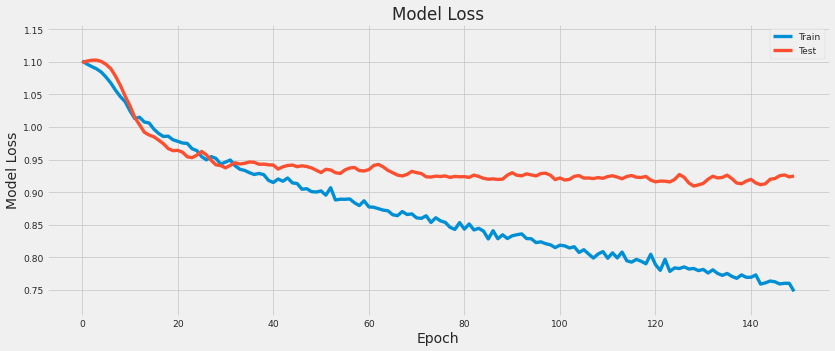

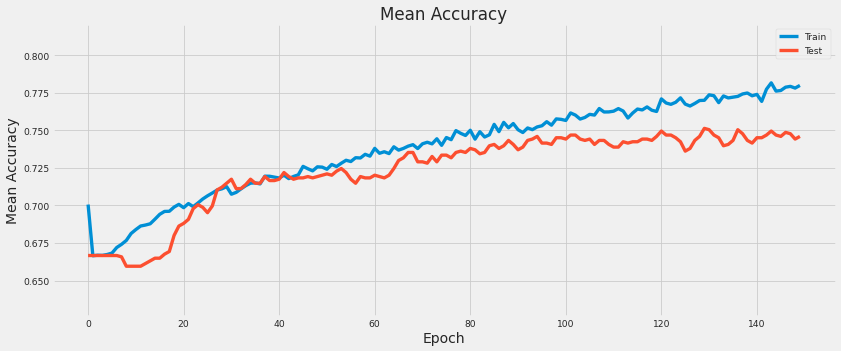

In [171]:
# Plot train vs validation loss during training
plot_results(history.history['loss'], history.history['val_loss'], 'Model Loss')

# Plot train vs validation accuracy during training
plot_results(history.history['accuracy'], history.history['val_accuracy'], 'Mean Accuracy')

In [172]:
print('Model Evaluation Loss: {:.3f}'.format(model.evaluate(X_valid, y_valid)[0]))

12/12 [==============================] - 0s 1ms/step - loss: 0.9248 - accuracy: 0.7460 - auc: 0.6954
Model Evaluation Loss: 0.925


Loading the best model weights

In [173]:
model.load_weights('../model/best_model.hdf5')
model.evaluate(X_valid, y_valid)

12/12 [==============================] - 0s 1ms/step - loss: 0.9094 - accuracy: 0.7460 - auc: 0.6973


[0.9093891382217407, 0.745989203453064, 0.697329580783844]

### Model Performance

In [174]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Append the predicted results with the actual validation results for comparsion

In [175]:
y_valid_org['predicted_range'] = np.argmax(model.predict(X_valid), axis=1)

#### Confusion Matrix

For a good enough model and given that the trading strategy is to go long on those securities predicted to have at least 10% returns (Category A) and to go short on those securities predicted to have at least -10% returns (Category C), we need the precision of A and C to be high.  In particularly, numbers at the bottom-left and top-right to be small.

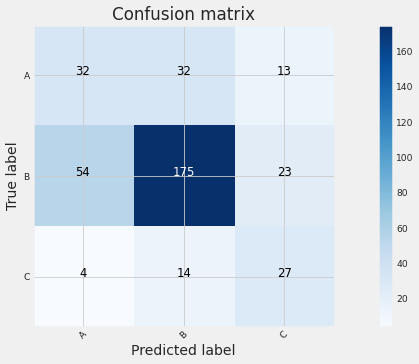

In [176]:
#importing confusion matrix

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_valid_org['return_range'], y_valid_org['predicted_range'])

plot_confusion_matrix(confusion, ['A','B','C'], False)
plt.show()

#### Classification Report

In [177]:
from sklearn.metrics import classification_report

print(classification_report(y_valid_org['return_range'], y_valid_org['predicted_range'], 
                            target_names=['A', 'B', 'C']))

              precision    recall  f1-score   support

           A       0.36      0.42      0.38        77
           B       0.79      0.69      0.74       252
           C       0.43      0.60      0.50        45

    accuracy                           0.63       374
   macro avg       0.53      0.57      0.54       374
weighted avg       0.66      0.63      0.64       374



## Stock Selection and Trading Strategy
- Using the model trained on past 3 years data: 2015-2017, predict the stocks that may outperform on each month betweeen 2018 to 2020 using factors observed on previous month respectively.
- The top **10** securities in category **A** based on predicted probability will be selected for the month to go **long**.  Only securities with predicted probability of at least 0.5 in that category is selected.  
- The top **10** securities in category **C** based on predicted probability will be selected for the month to go **short**.  Only securities with predicted probability of at least 0.5 in that category is selected.  
- All positions will be closed end of the month and the new batch of securites will be selected.
- Transaction cost is ignored in this analysis.
- Potentially, the model should be retrained based on the recent data available and using the updated model to perform stock selection.  However, due to complexity in retraining the models, this is not done in this analysis.

In [178]:
def applyStdScaler(data, columns, scaler_fitted):
    data_scaled = data.copy()
    data_scaled[columns] = scaler_fitted.transform(data[columns])
    return data_scaled

In [179]:
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta

def selectStockByMonth(predictmonth):

    datamonth = datetime.strptime(predictmonth, '%Y-%m') + relativedelta(months=-1)
    datamonth = datamonth.strftime("%Y-%m")

    test = getDataByDate(datamonth).reset_index(drop=True)

    test.dropna(axis=0, inplace=True)

    to_drop = ['code', 'next_mth_return']
    features = [column for column in test.columns if column not in to_drop]

    X = test[features]

    X_std = applyStdScaler(X, col_toscale, scaler)
    X_std = pd.DataFrame(X_std, columns=X.columns)

    predicted_category = np.argmax(model.predict(X_std), axis=1)
    predicted_probability = np.max(model.predict(X_std), axis=1)

    results = pd.DataFrame(test.code)
    results['predictmonth'] = predictmonth
    results['predicted_range'] = predicted_category
    results['predicted_prob'] = predicted_probability
    
    CONFIDENCE = 0.5
    NUM_OF_STOCKS = 20
    
    to_long = results[(results.predicted_range == 0) & 
                      (results.predicted_prob > CONFIDENCE)].sort_values('predicted_prob', 
                                                             ascending=False).head(NUM_OF_STOCKS)
    to_short = results[(results.predicted_range == 2) & 
                       (results.predicted_prob > CONFIDENCE)].sort_values('predicted_prob', 
                                                             ascending=False).head(NUM_OF_STOCKS)
    return to_long, to_short

In [180]:
def getSecurityName(symbol):
    security = security_list.loc[symbol]
    return security.display_name, security.stock_name

def getMonthlyReturn(date, symbol):
    return monthly_returns.loc[pd.IndexSlice[date, :], symbol].values[0]

In [181]:
def calcPortfolioReturn(stock_returns):
    
    num_stock = len(stock_returns)
    ## Assume equally weighted portfolio
    weights = np.ones(num_stock) / num_stock
    
    return sum(weights * stock_returns)

In [182]:
from matplotlib import patheffects

def plotTimeSeries(series, title='', xlabel='', ylabel='', tickermap=''): 
    FIG_SIZE = (20,8)
    ax = series.plot(figsize=FIG_SIZE, fontsize=12, linewidth=3, linestyle='-')
    ax.set_xlabel(xlabel, fontsize = 16)
    ax.set_ylabel(ylabel, fontsize = 16)
    
    title_text_obj = ax.set_title(title, fontsize = 18, verticalalignment = 'bottom')
    title_text_obj.set_path_effects([patheffects.withSimplePatchShadow()])
    # pe = patheffects.withSimplePatchShadow(offset = (1, -1), shadow_rgbFace = (1,0,0), calpha = 0.8)

    names = series.columns
    if tickermap:
        names = names.map(tickermap)
        
    ax.legend(names, fontsize = 16)
    plt.show()

Creating the months for stock return predictions

In [183]:
predict_startdate = '2018-01-01'
predict_enddate = '2020-07-01'
predict_months = pd.date_range(predict_startdate, predict_enddate, freq='M').strftime("%Y-%m").tolist()

In [184]:
print(predict_months)

['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06']


Prepare both long and short security selection and fetch their respective actual returns for each month

In [185]:
predicted_tolong = []
predicted_toshort = []

for month in predict_months:
    to_long, to_short = selectStockByMonth(month)
    predicted_tolong.append(to_long)   
    predicted_toshort.append(to_short) 

predicted_tolong = pd.concat(predicted_tolong).reset_index(drop=True)
predicted_toshort = pd.concat(predicted_toshort).reset_index(drop=True)
predicted_tolong['type'] = 'Long'
predicted_toshort['type'] = 'Short'

In [186]:
predicted_tolong['monthly_returns'] = predicted_tolong.apply(
    lambda x: getMonthlyReturn(x['predictmonth'], x['code']), axis=1)
predicted_toshort['monthly_returns'] = predicted_toshort.apply(
    lambda x: -1 * getMonthlyReturn(x['predictmonth'], x['code']), axis=1)

predicted_results = pd.concat([predicted_tolong, predicted_toshort])
predicted_results['display_name'] = predicted_results['code'].apply(lambda x: getSecurityName(x)[0])
predicted_results['name'] = predicted_results['code'].apply(lambda x: getSecurityName(x)[1])

In [187]:
predicted_results

,code,predictmonth,predicted_range,predicted_prob,type,monthly_returns,display_name,name
0,002120.XSHE,2018-01,0,0.702328,Long,-0.063945,韵达股份,YDGF
1,600029.XSHG,2018-01,0,0.678536,Long,-0.011986,南方航空,NFHK
2,600547.XSHG,2018-01,0,0.626887,Long,0.018979,山东黄金,SDHJ
3,600516.XSHG,2018-01,0,0.604906,Long,0.026194,方大炭素,FDTS
4,002001.XSHE,2018-01,0,0.595481,Long,0.033654,新和成,XHC
...,...,...,...,...,...,...,...,...
145,603288.XSHG,2020-06,2,0.657874,Short,-0.082681,海天味业,HTWY
146,300059.XSHE,2020-06,2,0.653877,Short,-0.417544,东方财富,DFCF
147,603986.XSHG,2020-06,2,0.601100,Short,-0.219867,兆易创新,ZYCX
148,300015.XSHE,2020-06,2,0.588870,Short,-0.109551,爱尔眼科,AEYK


In [188]:
predicted_results.to_csv('../output/stock_selection.csv', index=True)

Prepare portfolio monthly returns

In [189]:
portfolio_monthly_returns = pd.DataFrame(predict_months, 
                                         columns = ['predictmonth']).set_index('predictmonth')
portfolio_monthly_returns = portfolio_monthly_returns. \
                                join(predicted_results. \
                                groupby('predictmonth')['monthly_returns']. \
                                agg(calcPortfolioReturn), how='left')
portfolio_monthly_returns = portfolio_monthly_returns.fillna(0, axis=1)
portfolio_monthly_returns.index = pd.to_datetime(portfolio_monthly_returns.index)
portfolio_monthly_returns['cumulative_returns'] = ((1 + portfolio_monthly_returns).cumprod()-1) 

Show benchmark information and time series

沪深300


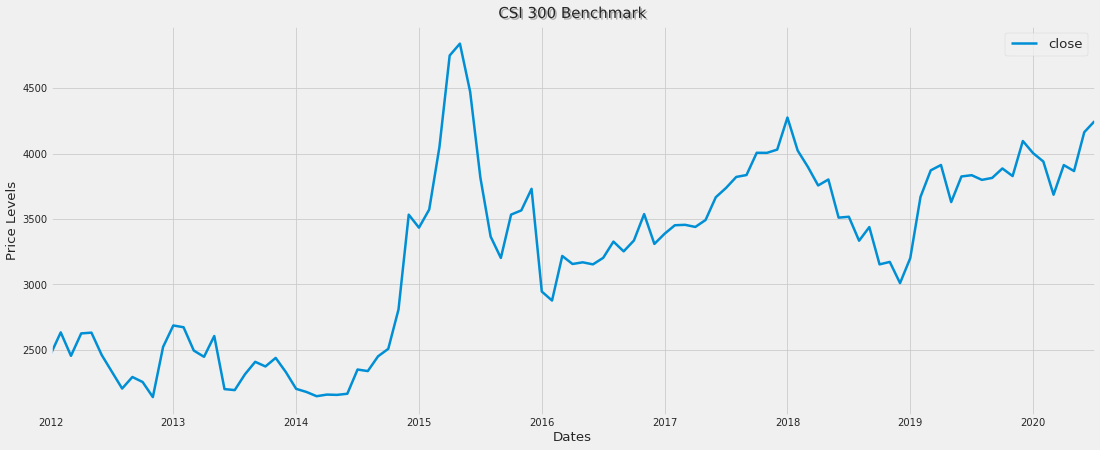

In [190]:
bmk_name = getSecurityName('000300.XSHG')[0]
print(bmk_name)
plotTimeSeries(bmk_prices, 'CSI 300 Benchmark', 'Dates', 'Price Levels')

Calculate benchmark returns for comparison

In [191]:
bmk_prices = bmk_prices.resample('M').fillna('ffill')
bmk_returns = bmk_prices.pct_change().dropna(axis=0, how='all')
bmk_returns = pd.DataFrame(bmk_returns)
bmk_returns.columns = ['bmk_monthly_returns']
bmk_returns.index = bmk_returns.index.map(lambda t: t.replace(day=1))
bmk_returns = bmk_returns['2018':'2020']
bmk_returns['bmk_cumulative_returns'] = ((1 + bmk_returns).cumprod()-1) 

Join benchmark returns to portfolio returns

In [192]:
portfolio_monthly_returns = portfolio_monthly_returns.join(bmk_returns, how='left')

### Portfolio Performance

It is observed that the portfolio cumulative returns (red line) are consistently above the benchmark cumulative returns (green line).  On other words, the portfolio performance outperforms the benchmark consistently over the months.

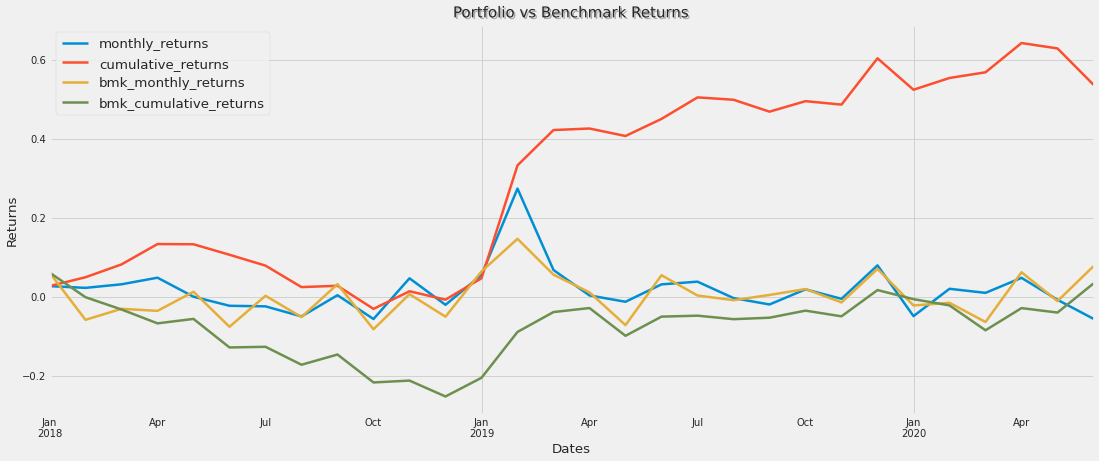

In [193]:
plotTimeSeries(portfolio_monthly_returns, 'Portfolio vs Benchmark Returns', 
               'Dates', 'Returns')

In [194]:
portfolio_monthly_returns

,monthly_returns,cumulative_returns,bmk_monthly_returns,bmk_cumulative_returns
predictmonth,,,,
2018-01-01,0.026328,0.026328,0.060794,0.060794
2018-02-01,0.021910,0.048815,-0.058996,-0.001789
2018-03-01,0.030950,0.081275,-0.031101,-0.032834
2018-04-01,0.047669,0.132819,-0.036327,-0.067968
2018-05-01,-0.000466,0.132291,0.012111,-0.056680
2018-06-01,-0.023450,0.105739,-0.076636,-0.128973
2018-07-01,-0.024903,0.078203,0.001903,-0.127316
2018-08-01,-0.050416,0.023845,-0.052069,-0.172755
2018-09-01,0.003285,0.027208,0.031297,-0.146865


In [195]:
portfolio_monthly_returns.to_csv('../output/portfolio_monthly_returns.csv', index=True)

## Concluding Notes

1. Model should be retrained on monthly basis with the most recent data to reflect the most market events.  I expect such retraining to contribute better portfolio performance especially during stress period.
2. Accuracy at around 60% is not fantastic.  Precision is not there and there are a number of False Positives.  Eg: Model predicted Category C but the actual Category is A and vice versa.  Better factor selection and other deep learning model structures should be explored.
3. List of factors are selected based on the reference list found on the first research paper.  Other factors can be consider.  Important factors can be identified and updated on a monthly basis.  Can explore using only the top important factors to reduce noisy and overfitting.
4. This analysis focuses on data from JoinQuant and securities inside CSI300.  This can be easily extended to other securities found on different indices as long as the factor data are available.
5. Understanding the factors and respective calculation methodology provided by JoinQuant is important.  This will help in factor selection and explaining why the factors are selected for each time period.


# Thank you

Thanks to JoinQuant (聚宽) for providing such a platform and the necessary data for me to complete such an analysis.